In [ ]:
from librosa.core import load as ld_wav
from librosa.feature import delta
import librosa.feature as ft_extraction
import scipy.io.wavfile as wav
import numpy as np
import os
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,make_scorer,f1_score
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
import pandas as pd
import librosa
from operator import itemgetter
import pickle
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC,Precision,Recall,BinaryCrossentropy,Accuracy
drive.mount('/content/drive')
!cp "/content/drive/My Drive/IRMAS-training/PNCC-master/pncc.py" .
import pncc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Extraction

In [ ]:
!ls "/content/drive/My Drive/IRMAS-training"

best_params.txt   data_dict_procVoz.pickle  MFCCresults  PCA  PNCC-master  vio
data_dict.pickle  KPCA			    Original	 pia  resultados


In [ ]:
# directory where we your .wav files are
directoryName = "/content/drive/My Drive/IRMAS-training" # put your own directory here
#instruments to evaluate
instruments = ["pia","vio"]
# directory to put our results in, you can change the name if you like
resultsDirectory = directoryName + "/MFCCresults"


In [ ]:
def countTrainTracks(input_path, labels):
		""" Counts the number of tracks in the folders of the trainset
		"""
		total = 0
		for l, label in enumerate(labels):
			instrument_dir = os.path.join(input_path, label)
			total += len(os.listdir(instrument_dir))

		return total

In [ ]:
if not os.path.exists(resultsDirectory):
    os.makedirs(resultsDirectory)

In [ ]:
total_tracks = countTrainTracks(directoryName,instruments)
print("Total tracks: ",total_tracks)

Total tracks:  1301


In [ ]:
data_dict = dict()
data_dict["rolloff"] = list()
data_dict["bandwidth"] = list()
data_dict["centroids"] = list()
data_dict["zero_crossing_rate"] = list()
data_dict["rms"] = list()
data_dict["slope"] = list()
data_dict["kurtosis"] = list()
data_dict["skewness"] = list()
for i in range(0,13):
    data_dict["mfcc"+str(i)] = list()
    data_dict["pncc"+str(i)] = list()
data_dict["instrument"] = list()

In [ ]:
#Essa funcao recebe cada coluna mfcc[j], que é um vetor onde cada elemento vetor[i]
#contem todos os K coeficientes mfcc[j] de um audio i. O objetivo é descobrir como os MFCC[j] mudam ao longo do tempo.
#Obs: 
#j (quantidade de coeficientes MFCC) = {0,13}, 
#k (quantidade de uma mesma caracteristica extraída do audio completo - depende do tamanho de janela e do tempo de duração) = {0,130}, 
#i (numero de arquivos do dataset) = 1301 
def getDeltaFeat(column):
    #Quantos vetores serão lidos, ou seja, o tamanho do dataset 
    original_len = len(column)
    deltas = list()
    for i in range(original_len):
      deltas.append(delta(column[i], order=1))
    return np.array(deltas)

In [ ]:
def includeDeltaFeat(df):
    for i in range(0,13):
        df["delta_mfcc"+str(i)]=getDeltaFeat(df["mfcc"+str(i)])
        df["delta_pncc"+str(i)]=getDeltaFeat(df["pncc"+str(i)])
    return df

In [ ]:
def FeatureSpectralCentroid(X, f_s):

    isSpectrum = X.ndim == 1

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0, keepdims=True)
    norm[norm == 0] = 1

    vsc = np.dot(np.arange(0, X.shape[0]), X) / norm

    # convert from index to Hz
    vsc = vsc / (X.shape[0] - 1) * f_s / 2

    # if input is a spectrum, output scaler else if spectrogram, output 1d array
    vsc = np.squeeze(vsc) if isSpectrum else np.squeeze(vsc, axis=0)

    return vsc

In [ ]:
def FeatureSpectralSpread(X, f_s):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    # get spectral centroid as index
    vsc = FeatureSpectralCentroid(X, f_s) * 2 / f_s * (X.shape[0] - 1)

    # X = X**2 removed for consistency with book

    norm = X.sum(axis=0)
    norm[norm == 0] = 1

    # compute spread
    vss = np.zeros(X.shape[1])
    indices = np.arange(0, X.shape[0])
    for n in range(0, X.shape[1]):
        vss[n] = np.dot((indices - vsc[n])**2, X[:, n]) / norm[n]

    vss = np.sqrt(vss)

    # convert from index to Hz
    vss = vss / (X.shape[0] - 1) * f_s / 2

    return np.squeeze(vss) if isSpectrum else vss

In [ ]:
def FeatureSpectralKurtosis(X, f_s, UseBookDefinition=False):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    if UseBookDefinition:  # not recommended
        # compute mean and standard deviation
        mu_x = np.mean(X, axis=0, keepdims=True)
        std_x = np.std(X, axis=0)

        # remove mean
        X = X - mu_x

        # compute kurtosis
        vsk = np.sum(X**4, axis=0) / (std_x**4 * X.shape[0])
    else:
        f = np.arange(0, X.shape[0]) / (X.shape[0] - 1) * f_s / 2
        # get spectral centroid and spread (mean and std of dist)
        vsc = FeatureSpectralCentroid(X, f_s)  # *2/f_s * (X.shape[0]-1)
        vss = FeatureSpectralSpread(X, f_s)    # *2/f_s * (X.shape[0]-1)

        norm = X.sum(axis=0)
        norm[norm == 0] = 1
        vss[vss == 0] = 1

        # compute kurtosis
        vsk = np.zeros(X.shape[1])
        for n in range(0, X.shape[1]):
            vsk[n] = np.dot((f - vsc[n])**4, X[:, n]) / (vss[n]**4 * norm[n] * X.shape[0])

    return np.squeeze(vsk - 3) if isSpectrum else (vsk - 3)

In [ ]:
def FeatureSpectralSkewness(X, f_s, UseBookDefinition=False):

    isSpectrum = X.ndim == 1
    if isSpectrum:
        X = np.expand_dims(X, axis=1)

    if UseBookDefinition:  # not recommended
        # compute mean and standard deviation
        mu_x = np.mean(X, axis=0, keepdims=True)
        std_x = np.std(X, axis=0)

        # remove mean
        X = X - mu_x

        # compute kurtosis
        vssk = np.sum(X**3, axis=0) / (std_x**3 * X.shape[0])
    else:
        f = np.arange(0, X.shape[0]) / (X.shape[0] - 1) * f_s / 2
        # get spectral centroid and spread (mean and std of dist)
        vsc = FeatureSpectralCentroid(X, f_s) 
        vss = FeatureSpectralSpread(X, f_s)   

        norm = X.sum(axis=0)
        norm[norm == 0] = 1
        vss[vss == 0] = 1

        # compute spread
        vssk = np.zeros(X.shape[1])
        for n in range(0, X.shape[1]):
            vssk[n] = np.dot((f - vsc[n])**3, X[:, n]) / (vss[n]**3 * norm[n] * X.shape[0])

    return np.squeeze(vssk) if isSpectrum else vssk

In [ ]:
def FeatureSpectralSlope(X, f_s):

    # compute mean
    mu_x = X.mean(axis=0, keepdims=True)

    # compute index vector
    kmu = np.arange(0, X.shape[0]) - X.shape[0] / 2

    # compute slope
    X = X - mu_x
    vssl = np.dot(kmu, X) / np.dot(kmu, kmu)

    return vssl

In [ ]:
(sig,rate) = ld_wav(directoryName +"/"+'pia'+"/" +'001__[pia][nod][cla]1389__1.wav')
spectogram = np.abs(librosa.stft(sig,n_fft=512))
feat = FeatureSpectralSlope(spectogram,rate)
print(np.array(feat).reshape(1,-1).shape)

(1, 517)


In [ ]:
feat = pncc.pncc(audio_wave=sig, n_fft=512, sr=rate, winlen=0.0232, winstep=0.0232/4,n_mels=128, n_pncc=13)
feat.shape

(517, 13)

In [ ]:
mfcc_feat = ft_extraction.mfcc(S=spectogram,sr=rate,n_mfcc=13)
mfcc_feat.shape

(13, 517)

In [ ]:
ft_extraction.zero_crossing_rate(y=sig,frame_length=512,hop_length=512//4).shape

(1, 517)

In [ ]:
len(sig)

66150

In [ ]:
def zeroPadding(sig,wav_len = 66150):
  left_zeros = np.zeros(wav_len - sig.shape[0])
  return np.hstack([left_zeros,sig])

In [ ]:
def getData(directoryName,instruments,data_dict):
    instrument_index = 0
    files_read = 0
    for instrument in instruments:
        for filename in os.listdir(directoryName+"/"+instrument):
            if filename.endswith('.wav'): # only get MFCCs from .wavs
                # read in our file
                (sig,rate) = ld_wav(directoryName +"/"+instrument+"/" +filename)
                sig = zeroPadding(sig)
                # get mfcc
                spectogram = np.abs(librosa.stft(sig,n_fft=512))
                mfcc_feat = ft_extraction.mfcc(S=spectogram,sr=rate,n_mfcc=13)
                pncc_feat = pncc.pncc(audio_wave=sig, n_fft=512, sr=rate, 
                                 winlen=0.0232, winstep=0.0232/4,
                                 n_mels=128, n_pncc=13)
                rolloff_feat = ft_extraction.spectral_rolloff(S=spectogram,sr=rate)
                bandwidth_feat = ft_extraction.spectral_bandwidth(S=spectogram,sr=rate,)
                centroid_feat = ft_extraction.spectral_centroid(S=spectogram,sr=rate)
                zero_crossing_rate_feat = ft_extraction.zero_crossing_rate(y=sig,frame_length=512,hop_length=512//4)
                rms_feat = ft_extraction.rms(S=spectogram)
                slope_feat = FeatureSpectralSlope(spectogram,rate)
                slope_feat = np.array(slope_feat).reshape(1,-1)
                kurtosis_feat = FeatureSpectralKurtosis(spectogram,rate)
                kurtosis_feat = np.array(kurtosis_feat).reshape(1,-1)
                skewness_feat = FeatureSpectralSkewness(spectogram,rate)
                skewness_feat = np.array(skewness_feat).reshape(1,-1)
                data_dict["instrument"].append([instrument_index])
                for i in range(0,13):
                  data_dict["mfcc"+str(i)].append(mfcc_feat[i])
                  data_dict["pncc"+str(i)].append(pncc_feat[:,i])
                data_dict["rolloff"].append(rolloff_feat[0])
                data_dict["bandwidth"].append(bandwidth_feat[0])
                data_dict["centroids"].append(centroid_feat[0])
                data_dict["zero_crossing_rate"].append(zero_crossing_rate_feat[0])
                data_dict["rms"].append(rms_feat[0])
                data_dict["slope"].append(slope_feat[0])
                data_dict["kurtosis"].append(kurtosis_feat[0])
                data_dict["skewness"].append(skewness_feat[0])
                # create a file to save our results in
                files_read += 1
        instrument_index += 1
    data_dict = includeDeltaFeat(data_dict)
    return data_dict                                                                                           

In [ ]:
data_dict = getData(directoryName,instruments,data_dict)
with open(directoryName+"/data_dict_procVoz_pncc.pickle","wb") as f:
  pickle.dump(data_dict,f)

In [ ]:
with open(directoryName+"/data_dict_procVoz.pickle","rb") as f:
  data_dict = pickle.load(f)

In [ ]:
len(data_dict["bandwidth"][0])

517

In [ ]:
np.count_nonzero(~np.isnan(data_dict["mfcc0"]))

672617

In [ ]:
for key in data_dict.keys():
    print(key,len(data_dict[key]))
    #convert list to np
    data_dict[key] = np.array(data_dict[key])

rolloff 1301
bandwidth 1301
centroids 1301
zero_crossing_rate 1301
rms 1301
slope 1301
kurtosis 1301
mfcc0 1301
pncc0 1301
mfcc1 1301
pncc1 1301
mfcc2 1301
pncc2 1301
mfcc3 1301
pncc3 1301
mfcc4 1301
pncc4 1301
mfcc5 1301
pncc5 1301
mfcc6 1301
pncc6 1301
mfcc7 1301
pncc7 1301
mfcc8 1301
pncc8 1301
mfcc9 1301
pncc9 1301
mfcc10 1301
pncc10 1301
mfcc11 1301
pncc11 1301
mfcc12 1301
pncc12 1301
instrument 1301
delta_mfcc0 1301
delta_mfcc1 1301
delta_mfcc2 1301
delta_mfcc3 1301
delta_mfcc4 1301
delta_mfcc5 1301
delta_mfcc6 1301
delta_mfcc7 1301
delta_mfcc8 1301
delta_mfcc9 1301
delta_mfcc10 1301
delta_mfcc11 1301
delta_mfcc12 1301


In [ ]:
data_dict["rolloff"].shape[0]

1301

In [ ]:
#Para o datafram não aceita matriz como input. Como cada arquivo de audio do data se obtem uma matriz de 
#tamanho (tam,n_features) multiplicaremos cada elemento do vetor de saída por esse tamanho. Assim, para um dado audio e para cada linha
#da matriz de dados teremos um valor de saída corresponde. A representação com matriz será util quando utilizarmos redes neurais
#O metodo flatten() transforma 2d arrays em 1d
data_for_df = dict()
data_for_df['instrument'] = list()
for key in data_dict.keys():
  if key != 'instrument':
    data_for_df[key] = data_dict[key].flatten()
    print("Feat {} has len {}".format(key,len(data_for_df[key])))
  else:
    for i in range(len(data_dict['instrument'])):
      data_for_df['instrument'].extend([data_dict['instrument'][i][0]] * len(data_dict['bandwidth'][i]))
df = pd.DataFrame.from_dict(data_for_df)

Feat rolloff has len 672617
Feat bandwidth has len 672617
Feat centroids has len 672617
Feat zero_crossing_rate has len 672617
Feat rms has len 672617
Feat slope has len 672617
Feat kurtosis has len 672617
Feat mfcc0 has len 672617
Feat mfcc1 has len 672617
Feat mfcc2 has len 672617
Feat mfcc3 has len 672617
Feat mfcc4 has len 672617
Feat mfcc5 has len 672617
Feat mfcc6 has len 672617
Feat mfcc7 has len 672617
Feat mfcc8 has len 672617
Feat mfcc9 has len 672617
Feat mfcc10 has len 672617
Feat mfcc11 has len 672617
Feat mfcc12 has len 672617
Feat delta_mfcc0 has len 672617
Feat delta_mfcc1 has len 672617
Feat delta_mfcc2 has len 672617
Feat delta_mfcc3 has len 672617
Feat delta_mfcc4 has len 672617
Feat delta_mfcc5 has len 672617
Feat delta_mfcc6 has len 672617
Feat delta_mfcc7 has len 672617
Feat delta_mfcc8 has len 672617
Feat delta_mfcc9 has len 672617
Feat delta_mfcc10 has len 672617
Feat delta_mfcc11 has len 672617
Feat delta_mfcc12 has len 672617


In [ ]:
len(data_dict[key].flatten())

672617

In [ ]:
517*1301

672617

(1301x130)x31

In [ ]:
input_variables = list(df.columns)
input_variables.remove("instrument")
output_variable = "instrument"
print(input_variables)

['rolloff', 'bandwidth', 'centroids', 'zero_crossing_rate', 'rms', 'slope', 'kurtosis', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'delta_mfcc0', 'delta_mfcc1', 'delta_mfcc2', 'delta_mfcc3', 'delta_mfcc4', 'delta_mfcc5', 'delta_mfcc6', 'delta_mfcc7', 'delta_mfcc8', 'delta_mfcc9', 'delta_mfcc10', 'delta_mfcc11', 'delta_mfcc12']


# Preprocessing

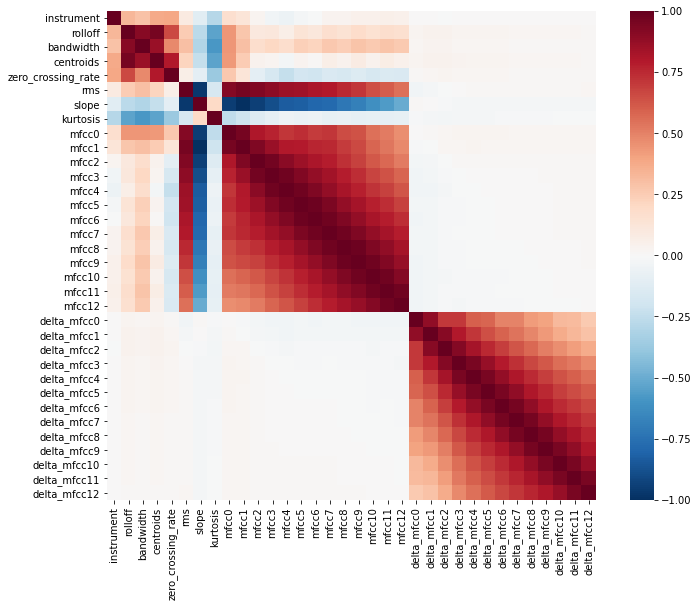

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,cmap=sns.color_palette("RdBu_r", 1000), vmin=-1,vmax=1, square=True)
plt.savefig('CorrelationMatrix.png')
plt.show()

In [ ]:
"""scaler = StandardScaler()
pca = PCA(n_components=0.9)
Y = df[output_variable]
df[input_variables] = scaler.fit_transform(df[input_variables])
df = pca.fit_transform(df[input_variables])
df = pd.DataFrame(df)
df[output_variable] = Y"""

'scaler = StandardScaler()\npca = PCA(n_components=0.9)\nY = df[output_variable]\ndf[input_variables] = scaler.fit_transform(df[input_variables])\ndf = pca.fit_transform(df[input_variables])\ndf = pd.DataFrame(df)\ndf[output_variable] = Y'

In [ ]:
"""percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
result = pca.explained_variance_ratio_
plt.bar(x= sorted(np.arange(len(result)),reverse=True), height=sorted(percent_variance,reverse=True),tick_label=np.round(sorted(pca.singular_values_,reverse=True),decimals=2) )
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component eigenvalue')
plt.xticks(rotation=90)
plt.title('PCA')
ax = plt.gca()
# set the xlimits to be the reverse of the current xlimits
ax.set_xlim(ax.get_xlim()[::-1])
# call `draw` to re-render the graph
plt.draw()

axes2 = plt.twinx()
axes2.plot(np.arange(len(result)),sorted(np.cumsum(result),reverse=True))
axes2.set_ylabel('cumulative explained variance')
plt.savefig('PCA.png')
plt.show()"""

"percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)\nresult = pca.explained_variance_ratio_\nplt.bar(x= sorted(np.arange(len(result)),reverse=True), height=sorted(percent_variance,reverse=True),tick_label=np.round(sorted(pca.singular_values_,reverse=True),decimals=2) )\nplt.ylabel('Percentate of Variance Explained')\nplt.xlabel('Principal Component eigenvalue')\nplt.xticks(rotation=90)\nplt.title('PCA')\nax = plt.gca()\n# set the xlimits to be the reverse of the current xlimits\nax.set_xlim(ax.get_xlim()[::-1])\n# call `draw` to re-render the graph\nplt.draw()\n\naxes2 = plt.twinx()\naxes2.plot(np.arange(len(result)),sorted(np.cumsum(result),reverse=True))\naxes2.set_ylabel('cumulative explained variance')\nplt.savefig('PCA.png')\nplt.show()"

In [ ]:
np.unique(df['instrument'])

array([0, 1])

In [ ]:
df.shape

(672617, 34)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(instruments)
print(le.inverse_transform([0,1]))

['pia' 'vio']


In [ ]:
df.columns

Index(['instrument', 'rolloff', 'bandwidth', 'centroids', 'zero_crossing_rate',
       'rms', 'slope', 'kurtosis', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'delta_mfcc0', 'delta_mfcc1', 'delta_mfcc2', 'delta_mfcc3',
       'delta_mfcc4', 'delta_mfcc5', 'delta_mfcc6', 'delta_mfcc7',
       'delta_mfcc8', 'delta_mfcc9', 'delta_mfcc10', 'delta_mfcc11',
       'delta_mfcc12'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[input_variables], df[output_variable], test_size=0.33, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Random Forest

In [ ]:
"""rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)"""

'rfc = RandomForestClassifier(n_estimators=100, random_state=0)\nrfc.fit(X_train, y_train)\ny_predict = rfc.predict(X_test)'

In [ ]:
"""print(metrics.confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict)))
print(metrics.classification_report(le.inverse_transform(y_test),le.inverse_transform(y_predict),digits=3))"""

'print(metrics.confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict)))\nprint(metrics.classification_report(le.inverse_transform(y_test),le.inverse_transform(y_predict),digits=3))'

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
  

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
"""plot_confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict), classes=['Piano', 'Violino'], title='Confusion matrix')
plt.savefig("ConfusionMatrix.png")"""

'plot_confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict), classes=[\'Piano\', \'Violino\'], title=\'Confusion matrix\')\nplt.savefig("ConfusionMatrix.png")'

In [ ]:
"""probs = rfc.predict_proba(X_test)
preds = probs[:,1]"""
def plot_AUC(preds,title,y_test):
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('ROC AUC - '+title)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.savefig('ROC_plot'+title+'.png')
  plt.show()

#plot_AUC(preds,"Random Forest",y_test)

# Neural Networks 

In [ ]:
#Converter o dicionario para uma unica matriz concatenando os arrays em colunas
X = np.array([data_dict[key] for key in input_variables])
Y = data_dict['instrument'].flatten()
# Anteriormente para cada conjunto de caracteristicas extraídas efetuamos a classificação. Logo tinhamos vetores de tamanho n_features 
# Agora, para uma determina sequencia de caracteristicas extraidas efetuaremos a classificação. Logo teremos agora uma matrix:
# (tam_seq,n_features). Consideraremos cada linha dessa matriz sendo o tempo
#X.shape == (31,1301,130)
#Mas queremos que X.shape = (1301,130,31)
X = np.transpose(X,(1,2,0))
X_train, X_test, y_train, y_test = train_test_split(X,Y,
                                                    test_size=0.33,
                                                    random_state=42)


In [ ]:
fitting_X = np.vstack([A for A in X_train])
fitting_Y = np.hstack([[y]*A.shape[0] for A,y in zip(X_train,y_train)])
kpca = Pipeline([
                  ("Nys",Nystroem(gamma=0.000001, random_state=42, n_components=800)),
                  ("PCA",PCA(n_components=10))
])
model = Pipeline([('kpca',kpca),
                  ('LR',LogisticRegression())
                  ])
"""kpca_search = {
   'kpca__Nys__n_components':Integer(200,800),
   'kpca__Nys__gamma': Real(0.001,1,prior='log-uniform')
}
opt = BayesSearchCV(
    model,
    [(kpca_search, 50)],
    scoring=make_scorer(f1_score),
    cv=5
)
opt.fit(fitting_X,fitting_Y)
print("val. score: %s" % opt.best_score_)
#print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))"""

'kpca_search = {\n   \'kpca__Nys__n_components\':Integer(200,800),\n   \'kpca__Nys__gamma\': Real(0.001,1,prior=\'log-uniform\')\n}\nopt = BayesSearchCV(\n    model,\n    [(kpca_search, 50)],\n    scoring=make_scorer(f1_score),\n    cv=5\n)\nopt.fit(fitting_X,fitting_Y)\nprint("val. score: %s" % opt.best_score_)\n#print("test score: %s" % opt.score(X_test, y_test))\nprint("best params: %s" % str(opt.best_params_))'

In [ ]:
#scores = cross_validate(model,fitting_X,fitting_Y,cv=5, scoring=make_scorer(f1_score),return_train_score=False)

In [ ]:
#np.mean(scores['test_score'])

In [ ]:
"""with open(directoryName+"/best_params.txt","w") as f:
  f.write(str(opt.best_params_))"""

'with open(directoryName+"/best_params.txt","w") as f:\n  f.write(str(opt.best_params_))'

In [ ]:
selected_train_data = []
selected_test_data = []
methodsNames = []
kpca = Pipeline([
                  ("Nys",Nystroem(gamma=0.000001, random_state=42, n_components=800)),
                  ("PCA",PCA(n_components=10))
])
FeatureSelectionMethods = []
FeatureSelectionMethods.append(PCA(n_components=len(input_variables)))
FeatureSelectionMethods.append(PCA(n_components=10))
FeatureSelectionMethods.append(kpca)
methodsNames.extend(['Original','PCA','KPCA'])
for fsm,method in zip(FeatureSelectionMethods,methodsNames):
  #os.mkdir(directoryName+"/input{}/".format(method))
  fsm.fit(fitting_X,fitting_Y)
  #np.save(directoryName+"/input{}/selected_train".format(method),selected_train_data)
  #selected_test_data = fsm.transform(X_test)
  #np.save(directoryName+"/input{}/selected_test".format(method),selected_test_data)

In [ ]:
fitting_X.shape

(450307, 33)

In [ ]:
y_train.shape

(871,)

In [ ]:
opt = tf.keras.optimizers.Nadam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
    name='NAdam'
)
#0.001

In [ ]:
def get_LSTM_Model(input_shape):
  model = Sequential()
  model.add(layers.BatchNormalization(input_shape=input_shape))
  model.add(layers.LSTM(32, return_sequences=True))
  model.add(layers.LSTM(32, return_sequences=True,dropout=0.8))
  model.add(layers.TimeDistributed(layers.Dense(32,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(16,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(8,activation='relu')))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32,activation='relu'))
  model.add(layers.Dense(16,activation='relu'))
  model.add(layers.Dense(8,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt,loss='binary_crossentropy')
  return model


In [ ]:
def get_RNN_Model(input_shape):
  model = Sequential()
  model.add(layers.BatchNormalization(input_shape=input_shape))
  model.add(layers.SimpleRNN(32, return_sequences=True))
  model.add(layers.SimpleRNN(32, return_sequences=True,dropout=0.8))
  model.add(layers.TimeDistributed(layers.Dense(32,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(16,activation='relu')))
  model.add(layers.TimeDistributed(layers.Dense(8,activation='relu')))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(32,activation='relu'))
  model.add(layers.Dense(16,activation='relu'))
  model.add(layers.Dense(8,activation='relu'))
  model.add(layers.Dense(1,activation='sigmoid'))
  model.summary()
  model.compile(optimizer=opt,loss='binary_crossentropy')
  return model


In [ ]:
def get_CNN_Model(input_shape):
    model = Sequential()
    model.add(layers.Conv2D(4,(3,3),activation='relu',input_shape=(input_shape),padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(8,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(16,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(32,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(64,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu',padding="same",strides=(1,1)))
    model.add(layers.MaxPooling2D((2,2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128,activation='relu'))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32,activation='relu'))
    model.add(layers.Dense(16,activation='relu'))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.summary()
    model.compile(optimizer=opt,loss='binary_crossentropy')
    return model

In [ ]:
class NN_model:
  def __init__(self,model_type,input_shape,allow_early_stop=False,load_from='',save_to=''):
    self.model_type = model_type
    #Pega o input shape, sendo o primeiro valor None para indicar que depende do tamanho do batch
    #input_shape 
    self.input_shape = input_shape
    self.save_to = save_to
    self.allow_early_stop = allow_early_stop
    if load_from == '':
      if model_type == 'RNN':
        self.model = get_RNN_Model(self.input_shape)
      if model_type == 'LSTM':
        self.model = get_LSTM_Model(self.input_shape)
      if model_type == 'CNN':
        self.model = get_CNN_Model(self.input_shape)
    else:
        self.model = tf.keras.models.load_model(load_from)
    

  def train(self,X,Y):   
    if self.allow_early_stop:
      earlystop_callback = tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss', min_delta=0.0001,
                            patience=50,
                            restore_best_weights=True
                            )
      #obtem um conjunto de validacao para evitar overfitting
      X_train, X_val, y_train, y_val  = train_test_split(X,Y, test_size=0.2, random_state=42)  
      self.model.fit(X_train,y_train,epochs=100,shuffle=True,
                     validation_data=(X_val,y_val),
                     callbacks=[earlystop_callback])
    else:
      self.model.fit(X,Y,epochs=100,shuffle=True)
    if self.save_to != '':
      self.model.save(self.save_to)

  
  def test(self,X_test,y_test,plot_results=True):
    nn_output = self.model.predict(X_test)
    if plot_results:
      y_predict = np.round(nn_output)
      y_predict = list(y_predict.astype('int16').flatten())
      y_test = list(y_test.flatten())   
      print(metrics.confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict)))
      print(metrics.classification_report(le.inverse_transform(y_test),le.inverse_transform(y_predict),digits=3))
      plot_confusion_matrix(le.inverse_transform(y_test),le.inverse_transform(y_predict), classes=['Piano', 'Violino'], title='Confusion matrix')
      plt.savefig("ConfusionMatrix"+self.model_type+".png")
      plt.show()      
      plot_AUC(nn_output,self.model_type,y_test)
    return nn_output



In [ ]:
def getExtractionModel(up_to=1,model=None):
  extractor = Sequential()
  for i in range(up_to):
    extractor.add(model.layers[i])
  return extractor

In [ ]:
def getExtractedFeats(X_train,X_test,y_train,y_test,model,method):
  os.mkdir(directoryName+"/{}/Y_DATA".format(method))
  np.save(directoryName+"/{}/Y_DATA".format(method)+"/y_train",y_train)
  np.save(directoryName+"/{}/Y_DATA".format(method)+"/y_test",y_test)
  os.mkdir(directoryName+"/{}/layer0".format(method))
  np.save(directoryName+"/{}/layer0/extracted_train".format(method),X_train)
  np.save(directoryName+"/{}/layer0/extracted_test".format(method),X_test)
  for num in range(1,len(model.layers)):
    os.mkdir(directoryName+"/{}/layer{}".format(method,num))
    extractor = getExtractionModel(num,model)
    train_features = np.array(extractor.predict(X_train))
    np.save(directoryName+"/{}/layer{}/extracted_train".format(method,num),train_features)
    test_features = np.array(extractor.predict(X_test))
    np.save(directoryName+"/{}/layer{}/extracted_test".format(method,num),test_features)

## LSTM

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 517, 33)           132       
_________________________________________________________________
lstm_1 (LSTM)                (None, 517, 256)          296960    
_________________________________________________________________
time_distributed_20 (TimeDis (None, 517, 64)           16448     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 517, 32)           2080      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 517, 16)           528       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 517, 8)            136       
_________________________________________________________________
flatten_6 (Flatten)          (None, 4136)            

INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/LSTM_MODEL/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/LSTM_MODEL/assets


[[203  36]
 [ 36 155]]
              precision    recall  f1-score   support

         pia      0.849     0.849     0.849       239
         vio      0.812     0.812     0.812       191

    accuracy                          0.833       430
   macro avg      0.830     0.830     0.830       430
weighted avg      0.833     0.833     0.833       430



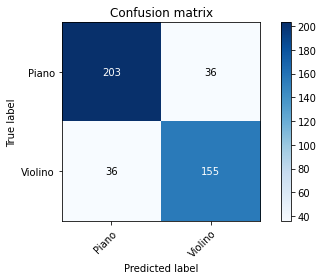

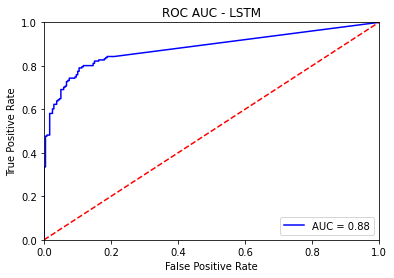

array([[0.7319661 ],
       [0.97536176],
       [0.4680396 ],
       [0.4680396 ],
       [0.9976203 ],
       [0.4680396 ],
       [0.5698311 ],
       [0.9905299 ],
       [0.99742997],
       [0.8534887 ],
       [0.9955494 ],
       [0.9993237 ],
       [0.99876815],
       [0.93992734],
       [0.9990879 ],
       [0.4680396 ],
       [0.5192605 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.53885406],
       [0.99992466],
       [0.99945414],
       [0.998701  ],
       [0.4680396 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.9966476 ],
       [0.4680396 ],
       [0.77163327],
       [0.4680396 ],
       [0.99817383],
       [0.4680396 ],
       [0.5539652 ],
       [0.46858054],
       [0.9999584 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.4680396 ],
       [0.51616424],
       [0.4680396 ],
       [0.65500027],
       [0.4680396 ],
       [0.4680396 ],
       [0.995

In [ ]:
myModel = NN_model('LSTM',X_train.shape[1:3],allow_early_stop=True,save_to=directoryName+'/LSTM_MODEL')
myModel.train(X_train,y_train)
myModel.test(X_test,y_test)

In [ ]:
myModel.model.save(directoryName+'/LSTM_MODEL')

## Simple RNN

(871, 517, 33)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 517, 33)           132       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 517, 32)           2112      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 517, 32)           2080      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 517, 32)           1056      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 517, 16)           528       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 517, 8)            136       
_________________________________________________________________
flatten_2 (Flatten)          (None, 41

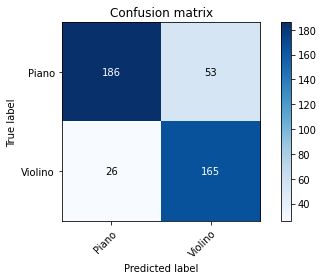

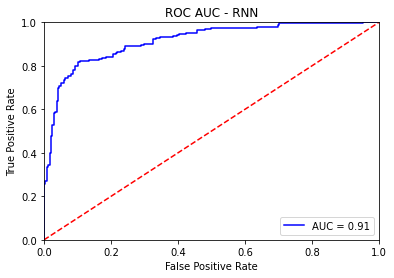

(871, 517, 10)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_6 (Batch (None, 517, 10)           40        
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 517, 32)           1376      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 517, 32)           2080      
_________________________________________________________________
time_distributed_9 (TimeDist (None, 517, 32)           1056      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 517, 16)           528       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 517, 8)            136       
_________________________________________________________________
flatten_3 (Flatten)          (None, 41

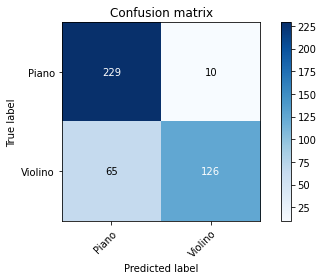

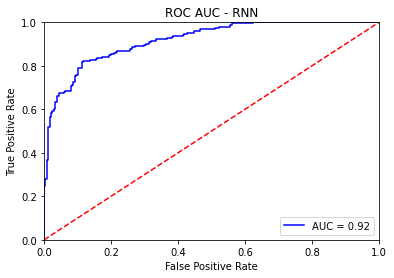

(871, 517, 10)
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 517, 10)           40        
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 517, 32)           1376      
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 517, 32)           2080      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 517, 32)           1056      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 517, 16)           528       
_________________________________________________________________
time_distributed_14 (TimeDis (None, 517, 8)            136       
_________________________________________________________________
flatten_4 (Flatten)          (None, 41

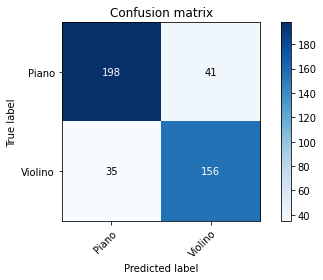

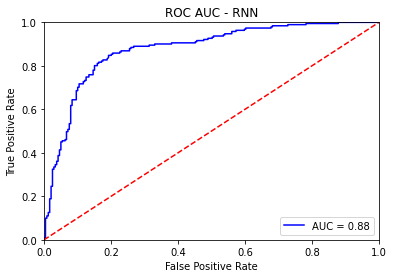

In [ ]:
for fsm,method in zip(FeatureSelectionMethods,methodsNames):
  X_train_t = np.array([fsm.transform(A) for A in X_train])
  X_test_t = np.array([fsm.transform(A) for A in X_test])
  print(X_train_t.shape)
  myModel2 = NN_model('RNN',input_shape=X_train_t.shape[1:3],
                      allow_early_stop=False,
                      save_to=(directoryName+'/{}/'.format(method)+'RNN_MODEL'))
  myModel2.train(X_train_t,y_train)
  myModel2.test(X_test_t,y_test)
  getExtractedFeats(X_train_t,X_test_t,y_train,y_test,myModel2.model,method)


Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 517, 10)           40        
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 517, 256)          68352     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 517, 64)           16448     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 517, 32)           2080      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 517, 16)           528       
_________________________________________________________________
time_distributed_23 (TimeDis (None, 517, 8)            136       
_________________________________________________________________
flatten_5 (Flatten)          (None, 4136)            

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


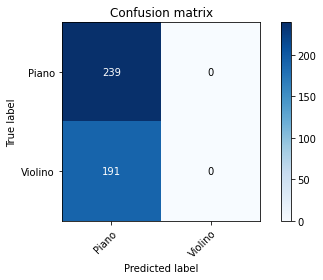

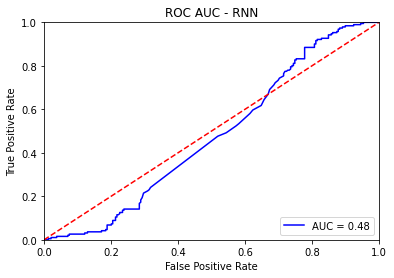

array([[0.42126846],
       [0.4212683 ],
       [0.4222697 ],
       [0.42126805],
       [0.42126775],
       [0.42117965],
       [0.42126846],
       [0.42126665],
       [0.42126834],
       [0.42074853],
       [0.42126846],
       [0.4212671 ],
       [0.42126846],
       [0.42126828],
       [0.42126846],
       [0.4212678 ],
       [0.42126703],
       [0.4212903 ],
       [0.4209739 ],
       [0.43491194],
       [0.4212684 ],
       [0.4211998 ],
       [0.4212678 ],
       [0.42126822],
       [0.42126858],
       [0.4213035 ],
       [0.42126808],
       [0.42121935],
       [0.4212686 ],
       [0.42132723],
       [0.4212676 ],
       [0.42126846],
       [0.4212689 ],
       [0.42126846],
       [0.42126834],
       [0.42126828],
       [0.4212684 ],
       [0.42126858],
       [0.42126834],
       [0.4212682 ],
       [0.4212618 ],
       [0.42116663],
       [0.42126837],
       [0.42121473],
       [0.421268  ],
       [0.42134815],
       [0.4212684 ],
       [0.421

In [ ]:
fsm,method = (FeatureSelectionMethods[2],methodsNames[2])
X_train_t = np.array([fsm.transform(A) for A in X_train])
X_test_t = np.array([fsm.transform(A) for A in X_test])
myModel2 = NN_model('RNN',input_shape=X_train_t.shape[1:3],allow_early_stop=False)
myModel2.train(X_train_t,y_train)
  #myModel2 = NN_model('RNN',input_shape=X_test_t.shape[1:3],load_from=directoryName+'/{}/'.format(method)+'RNN_MODEL')
myModel2.test(X_test_t,y_test)

In [ ]:
methodsNames[2]

'KPCA'

## CNN

In [ ]:
inp = list(X_train.shape[1:3])
inp.append(1)
inp

[517, 33, 1]

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 517, 33, 4)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 259, 17, 4)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 259, 17, 8)        296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 130, 9, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 130, 9, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 65, 5, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 5, 32)       

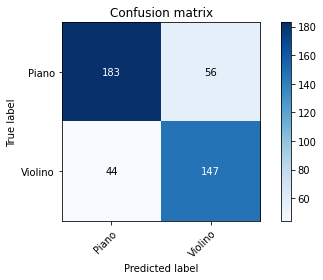

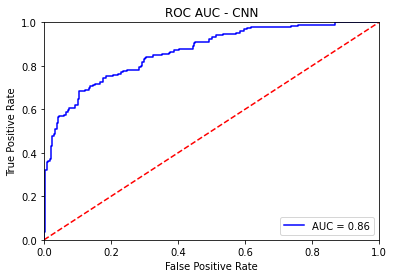

array([[8.85047317e-01],
       [9.77308154e-01],
       [7.63693452e-03],
       [2.21875608e-02],
       [6.48496926e-01],
       [2.16774702e-01],
       [4.77863669e-01],
       [9.61320758e-01],
       [8.79222393e-01],
       [8.50584090e-01],
       [4.20919418e-01],
       [9.63367045e-01],
       [7.48882771e-01],
       [9.52864170e-01],
       [9.83414531e-01],
       [3.25994968e-01],
       [8.51606727e-01],
       [6.97786689e-01],
       [2.93948859e-01],
       [5.78230619e-03],
       [2.35651284e-01],
       [9.48725581e-01],
       [8.98641825e-01],
       [8.69183362e-01],
       [2.87072003e-01],
       [1.42693251e-01],
       [3.49158347e-02],
       [9.37625766e-03],
       [6.16274893e-01],
       [5.14125526e-02],
       [9.11882281e-01],
       [9.22646224e-02],
       [9.01841164e-01],
       [1.57696038e-01],
       [4.39486384e-01],
       [9.35376763e-01],
       [9.53176141e-01],
       [2.90283829e-01],
       [8.42154026e-04],
       [1.60211951e-01],


In [ ]:
myModel3 = NN_model('CNN',inp,allow_early_stop=True,save_to=directoryName+'/CNN_MODEL')
train_reshaped = np.array(X_train)
test_reshaped = np.array(X_test)
train_reshaped = train_reshaped.reshape(-1,X_train.shape[1],X_train.shape[2],1)
test_reshaped = test_reshaped.reshape(-1,X_test.shape[1],X_test.shape[2],1)
myModel3.train(train_reshaped,y_train)
myModel3.test(test_reshaped,y_test)

INFO:tensorflow:Assets written to: /content/drive/My Drive/IRMAS-training/CNN_MODEL/assets
[[189  50]
 [ 45 146]]
              precision    recall  f1-score   support

         pia      0.808     0.791     0.799       239
         vio      0.745     0.764     0.755       191

    accuracy                          0.779       430
   macro avg      0.776     0.778     0.777       430
weighted avg      0.780     0.779     0.779       430



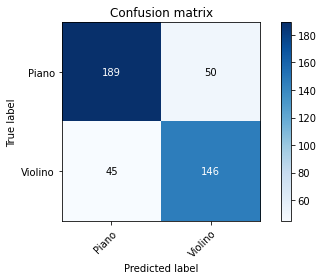

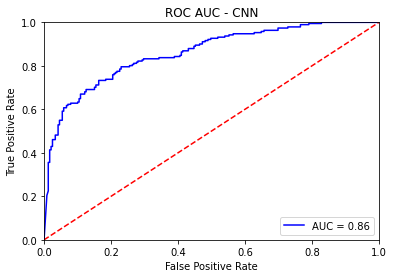

array([[8.24098706e-01],
       [9.99995470e-01],
       [1.44769197e-11],
       [2.35156585e-06],
       [3.57619703e-01],
       [3.13917141e-08],
       [9.44312778e-05],
       [9.99999762e-01],
       [5.11876762e-01],
       [9.96583879e-01],
       [5.55545986e-01],
       [9.99996781e-01],
       [9.99600768e-01],
       [9.99927163e-01],
       [1.00000000e+00],
       [1.80631876e-04],
       [9.99999404e-01],
       [9.98183131e-01],
       [4.48428392e-02],
       [1.25858221e-12],
       [6.13212585e-04],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99992788e-01],
       [1.48094594e-02],
       [7.42962956e-03],
       [3.67205138e-12],
       [3.09269817e-05],
       [9.93921041e-01],
       [4.92480103e-06],
       [9.99997735e-01],
       [1.25834242e-06],
       [9.99999762e-01],
       [2.51162946e-01],
       [9.23836708e-01],
       [9.99759436e-01],
       [1.00000000e+00],
       [2.76365876e-03],
       [2.78997762e-11],
       [3.59502792e-07],


In [ ]:
myModel3.model.save(directoryName+'/CNN_MODEL')
myModel3 = NN_model('CNN',inp,allow_early_stop=False,load_from=directoryName+'/CNN_MODEL')
train_reshaped = np.array(X_train)
test_reshaped = np.array(X_test)
train_reshaped = train_reshaped.reshape(-1,X_train.shape[1],X_train.shape[2],1)
test_reshaped = test_reshaped.reshape(-1,X_test.shape[1],X_test.shape[2],1)
myModel3.test(test_reshaped,y_test)